In [14]:
import neuraltda.topology2 as tp2
import pandas as pd
from joblib import Parallel, delayed
import datetime
import pickle
import glob
import os
from ephys import core, events, clust
import numpy as np
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import umap
import h5py as h5

In [2]:
# Bin The Data

# Correct/Incorrect
winSizes = [5.0, 10.0, 25.0, 50.0]
segmentInfo = [0, 0] # Sample + Target/Distractor period
#segmentInfo = [2500, 0] # Target+Distractor period
povers = 0.5

blockPath='/home/brad/emily/P01S15/'
widenarrow_threshold = 0.000230 # sw threshold in seconds

site = 'P01S18'
blockPath='/home/brad/emily/P01S18/'
widenarrow_threshold = 0.000240 # sw threshold in seconds

In [6]:
# Just correct vs. Incorrect
winSize = 50.0
cluster_group=['Good', 'MUA']
spikes = core.load_spikes(blockPath)
trials = events.load_trials(blockPath)
fs = core.load_fs(blockPath)
clusters = core.load_clusters(blockPath)

# get correct/incorrect trials
correctTrials = trials[trials['correct']==True]
incorrectTrials = trials[trials['correct']==False]

# Get wide/narrow clusters
clusters = core.load_clusters(blockPath)
clusters_list = clusters[clusters.quality.isin(cluster_group)]['cluster'].unique()
wide_clusters, narrow_clusters = clust.get_wide_narrow(blockPath, clusters_list, widenarrow_threshold)

In [8]:
periods = {'targ': [0, -2500], 'sd': [2500, 0]}
trial_types = {'correct': correctTrials, 'incorrect': incorrectTrials}
spike_widths = {'wide': np.array(wide_clusters, 'narrow': narrow_clusters}

period_labels = ['targ', 'sd']
trial_labels = ['correct', 'incorrect']
spike_labels = ['wide', 'narrow']

In [20]:
# build a data set of all the neural responses for all the conditions broken out by population type (wide narrow)
# Wide clusters
width = 'wide'
analysis_clus = spike_widths[width]
nclus = len(analysis_clus)
cluster_frame = clusters[clusters.cluster.isin(analysis_clus)]
dataset = {}
for period in period_labels:
    for trial_type in trial_labels:
        print('{} {} {}'.format(width, period, trial_type))
        # bin the appropriate data
        cluster_frame
        bfdict = tp2.do_dag_bin_lazy(blockPath, spikes, trial_types[trial_type], cluster_frame, fs, winSize,
                                    periods[period], cluster_group=['Good', 'MUA'],
                                    dt_overlap=0, comment='{}-{}-{}'.format(width, period, trial_type))
        bdf = glob.glob(os.path.join(bfdict['raw'], '*.binned'))[0]
        print(bdf)
        # extract population tensors
        poptensors = []
        with h5.File(bdf, 'r') as f:
            stims = list(f.keys())
            print('Stimuli: ', stims)
            for stim in stims:
                pt = np.array(f[stim]['pop_tens'])
                nclus2, nwin, ntrials = pt.shape
                print("Stimulus: {}   {} {} {}".format(stim, nclus2, nwin, ntrials))
                pt = np.reshape(pt, (nclus2, nwin*ntrials))
                print(pt.shape)
                poptensors.append(pt)
        dataset['{}-{}-{}'.format(width, period, trial_type)] = np.concatenate(poptensors, axis = 1)
        
        

wide targ correct
/home/brad/emily/P01S18/binned_data/win-50.0_dtovr-0_seg-0--2500-wide-targ-correct/20180608T181622Z-50.0-0.binned
Stimuli:  ['T23S15D-1', 'T23S15D44', 'T23S15D58', 'T23S15D60', 'T23S23D-1', 'T23S23D44', 'T23S23D52', 'T23S23D58', 'T58S44D-1', 'T58S44D15', 'T58S44D21', 'T58S44D23', 'T58S58D-1', 'T58S58D15', 'T58S58D23', 'T58S58D7']
Stimulus: T23S15D-1   43 40 22
(43, 880)
Stimulus: T23S15D44   43 40 18
(43, 720)
Stimulus: T23S15D58   43 40 26
(43, 1040)
Stimulus: T23S15D60   43 40 8
(43, 320)
Stimulus: T23S23D-1   43 40 20
(43, 800)
Stimulus: T23S23D44   43 40 20
(43, 800)
Stimulus: T23S23D52   43 40 11
(43, 440)
Stimulus: T23S23D58   43 40 25
(43, 1000)
Stimulus: T58S44D-1   43 40 34
(43, 1360)
Stimulus: T58S44D15   43 40 50
(43, 2000)
Stimulus: T58S44D21   43 40 13
(43, 520)
Stimulus: T58S44D23   43 40 29
(43, 1160)
Stimulus: T58S58D-1   43 40 30
(43, 1200)
Stimulus: T58S58D15   43 40 49
(43, 1960)
Stimulus: T58S58D23   43 40 31
(43, 1240)
Stimulus: T58S58D7   43 40 1

In [25]:
# Now concatenate all the conditions into one dataset with a corresponding label
datasets = list(dataset.keys())
concat_set = []
labels = []
for ind, ds in enumerate(datasets):
    concat_set.append(dataset[ds])
    labels.append(ind*np.ones(concat_set[-1].shape[1]))
    
concat_set = np.concatenate(concat_set, axis=1)
labels = np.concatenate(labels)

In [32]:
fit = umap.UMAP()
%time u = fit.fit_transform(concat_set.T)

CPU times: user 2min 43s, sys: 16.4 s, total: 3min
Wall time: 2min 6s


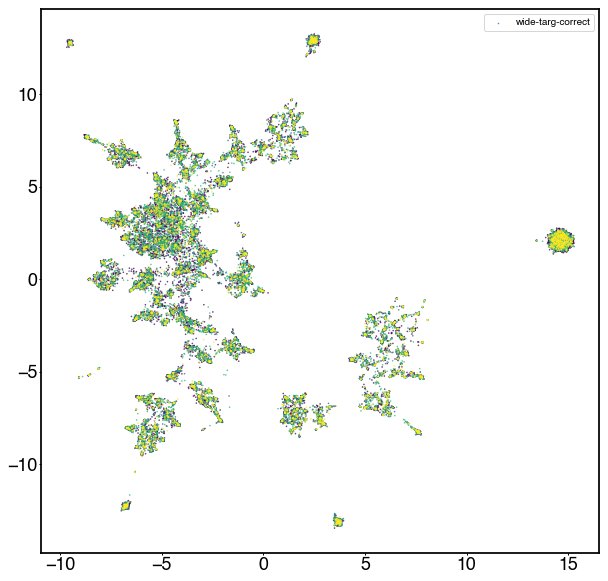

In [34]:
plt.style.use('/home/brad/code/NeuralTDA/gentnerlab.mplstyle')
plt.figure(figsize=(10, 10))
plt.scatter(u[:, 0], u[:, 1], s=1.5, c=labels, marker='.', alpha=0.75)
plt.legend(datasets)